# YOLO-KP SDNN Example

This tutorial demonstrates the inference of YOLO-KP SDNN (training example scripts [here](https://github.com/lava-nc/lava-dl/tree/main/tutorials/lava/lib/dl/slayer/tiny_yolo_sdnn)) on both CPU and Loihi 2 neurocore.

TODO: Add a diagram

TODO: Describe components

In addition, it also demonstrates the use of lava `Injector` and `Extractor` processes to reuse existing non-lava python modules and accelerate application development.

Switching between Loihi 2 hardware and CPU simulation is as simple as changing the run configuration settings.

<mark> NOTE: This example currently does not make use of high speed IO capabilities of Loihi. Once the software support is enabled in lava, it will be updated to use high speed IO. </mark>

In [1]:
import os
import yaml
import logging
from collections import deque

import numpy as np
import matplotlib.pyplot as plt

from lava.magma.core.run_conditions import RunSteps
from lava.magma.core.run_configs import Loihi2HwCfg, Loihi2SimCfg
from lava.proc import embedded_io as eio
from lava.proc import io

from lava.lib.dl import netx
from lava.lib.dl import slayer
from lava.lib.dl.slayer import obd

from utils import DataGenerator, YOLOPredictor, nms, YOLOMonitor
from IPython.display import display, clear_output

# Import modules for Loihi2 execution

Check if Loihi2 compiler is available and import related modules.

In [2]:
from lava.utils.system import Loihi2
Loihi2.preferred_partition = 'kp'
loihi2_is_available = Loihi2.is_loihi2_available

if loihi2_is_available:
    print(f'Running on {Loihi2.partition}')
    from lava.magma.compiler.subcompilers.nc.ncproc_compiler import CompilerOptions
    CompilerOptions.verbose = True
    compression = io.encoder.Compression.DELTA_SPARSE_8
else:
    print("Loihi2 compiler is not available in this system. "
          "This tutorial will execute on CPU backend.")
    compression = io.encoder.Compression.DENSE

Running on kp


## Set execution parameters

In [3]:
# Model arguments
trained_folder = os.path.abspath('../../slayer/tiny_yolo_sdnn/Trained_yolo_kp')
with open(trained_folder + '/args.txt', 'rt') as f:
    model_args = slayer.utils.dotdict(yaml.safe_load(f))

# Additional inference arguments
inference_args = slayer.utils.dotdict(loihi=loihi2_is_available,
                                      spike_exp=4,    # This sets the decimal/fraction precision of spike message to 4 bits
                                      num_steps=200)  # Number of frames to perform inference on

# Pre and post processing parameters
pre_args = slayer.utils.dotdict(input_mean=np.array([0.485, 0.456, 0.406]),  # Input normalization mean
                                input_std=np.array([0.229, 0.224, 0.225]))   #                     & std
post_args = slayer.utils.dotdict(anchors=np.array([(0.28, 0.22),  # YOLO head's anchor preset scales
                                                   (0.38, 0.48),
                                                   (0.90, 0.78)]))

## Load YOLO-KP network

In [4]:
net = netx.hdf5.Network(trained_folder + '/network.net',
                        skip_layers=1,  # First layer does delta encoding. We will only send it's sparsified output
                        input_message_bits=16,
                        spike_exp=inference_args.spike_exp)
print(f'The model was trained for {model_args.dataset} dataset')
print(f'\nNetwork Architecture ({model_args.model}):'); print('=' * (24 + len(model_args.model))); print(net)

The model was trained for BDD100K dataset

Network Architecture (yolo_kp):
|   Type   |  W  |  H  |  C  | ker | str | pad | dil | grp |delay|
|Conv      |  224|  224|   16| 3, 3| 2, 2| 1, 1| 1, 1|    1|False|
|Conv      |  112|  112|   32| 3, 3| 2, 2| 1, 1| 1, 1|    1|False|
|Conv      |   56|   56|   64| 3, 3| 2, 2| 1, 1| 1, 1|    1|False|
|Conv      |   28|   28|  128| 3, 3| 2, 2| 1, 1| 1, 1|    1|False|
|Conv      |   28|   28|  256| 3, 3| 1, 1| 1, 1| 1, 1|    1|False|
|Conv      |   14|   14|  256| 3, 3| 2, 2| 1, 1| 1, 1|    1|False|
|Conv      |   14|   14|  512| 3, 3| 1, 1| 1, 1| 1, 1|    1|False|
|Conv      |   14|   14|  256| 1, 1| 1, 1| 0, 0| 1, 1|    1|False|
|Conv      |   14|   14|  512| 3, 3| 1, 1| 1, 1| 1, 1|    1|False|
|Conv      |   14|   14|   48| 1, 1| 1, 1| 0, 0| 1, 1|    1|False|


## Dataset and input source

In [5]:
test_set = obd.dataset.BDD(root=model_args.path, dataset='track',
                           train=False, randomize_seq=False,
                           seq_len=inference_args.num_steps)
data_gen = DataGenerator(dataset=test_set, mean=pre_args.input_mean, std=pre_args.input_std)
quantize = netx.modules.Quantize(exp=6)  # convert to fixed point representation with 6 bit of fraction

## Input preprocessing and encoding

In [6]:
sender = io.injector.Injector(shape=net.inp.shape, buffer_size=128)
encoder = io.encoder.DeltaEncoder(shape=net.inp.shape,
                                  vth=net.net_config['layer'][0]['neuron']['vThMant'],
                                  spike_exp=0 if inference_args.loihi else net.spike_exp,
                                  num_bits=8,
                                  compression=compression)
if inference_args.loihi:
    # This is needed for the time being until high speed IO is enabled
    inp_adapter = eio.spike.PyToN3ConvAdapter(shape=encoder.s_out.shape,
                                              num_message_bits=16,
                                              spike_exp=net.spike_exp,
                                              compression=compression)

## Output decoding and post processing

In [7]:
if inference_args.loihi:
    # This is needed for the time being until high speed IO is enabled
    state_adapter = eio.state.ReadConv(shape=net.out.shape)
receiver = io.extractor.Extractor(shape=net.out.shape, buffer_size=128)
dequantize = netx.modules.Dequantize(exp=net.spike_exp + 12, num_raw_bits=24)
yolo_predictor = YOLOPredictor(anchors=post_args.anchors, clamp_max=model_args.clamp_max)


## Output visualization

In [8]:
def output_visualizer(annotated_frame, map_score, frame_idx):
    clear_output(wait=True)
    display(annotated_frame)
    print(f'Processed frame {frame_idx}')
    print(f'Object detection mAP@0.5 = {map_score:.2f}')
    
yolo_monitor = YOLOMonitor(viz_fx=output_visualizer, class_list=test_set.classes)

## Data buffers / delays

In [9]:
frame_buffer = netx.modules.FIFO(depth=len(net) + 1)
annotation_buffer = netx.modules.FIFO(depth=len(net) + 1)

# Connect Lava processes

In [10]:
if inference_args.loihi:
    sender.out_port.connect(encoder.a_in)
    encoder.s_out.connect(inp_adapter.inp)
    inp_adapter.out.connect(net.inp)
    state_adapter.connect_var(net.out_layer.neuron.sigma)
    state_adapter.out.connect(receiver.in_port)
else:
    sender.out_port.connect(encoder.a_in)
    encoder.s_out.connect(net.inp)
    net.out.connect(receiver.in_port)

# Setup execution

In [11]:
num_steps = inference_args.num_steps
run_condition = RunSteps(num_steps=num_steps, blocking=False)

if inference_args.loihi:
    exception_proc_model_map = {io.encoder.DeltaEncoder: io.encoder.PyDeltaEncoderModelSparse}
    run_config = Loihi2HwCfg(exception_proc_model_map=exception_proc_model_map)
else:
    exception_proc_model_map = {io.encoder.DeltaEncoder: io.encoder.PyDeltaEncoderModelDense}
    run_config = Loihi2SimCfg(select_tag='fixed_pt',
                              exception_proc_model_map=exception_proc_model_map)

# Run YOLO-KP inference

In [12]:
sender._log_config.level = logging.WARN
sender.run(condition=run_condition, run_cfg=run_config)

Partitioning converged after iteration=3
Per core utilization:
-------------------------------------------------------------------------
| AxonIn |NeuronGr| Neurons|Synapses| AxonMap| AxonMem|  Total |  Cores |
|-----------------------------------------------------------------------|
|   0.01%|  25.00%|  65.64%|  19.20%|  16.80%|   0.00%|  42.26%|       4|Conv(4, 14, 48)
|   0.01%|  12.50%|  87.52%|  86.40%|   0.35%|   0.17%|  87.47%|      32|Conv(8, 7, 64)
|   0.01%|  12.50%|  87.52%|  67.20%|   0.09%|   0.35%|  72.04%|      14|Conv(2, 7, 256)
|   0.01%|  12.50%|  87.52%|  86.40%|   0.35%|   0.35%|  87.61%|      32|Conv(8, 7, 64)
|   0.01%|  12.50%|  87.52%|  72.00%|   0.35%|   2.80%|  78.05%|      16|Conv(8, 7, 64)
|   0.01%|  12.50%|  87.52%|  79.20%|   0.17%|   0.17%|  81.57%|      56|Conv(4, 7, 128)
|   0.01%|  12.50%|  87.52%|  39.60%|   0.17%|   0.35%|  50.03%|      28|Conv(4, 7, 128)
|   0.01%|  12.50%|  87.52%|  10.80%|   0.35%|   0.17%|  26.99%|      56|Conv(4, 14, 64)
|   0.

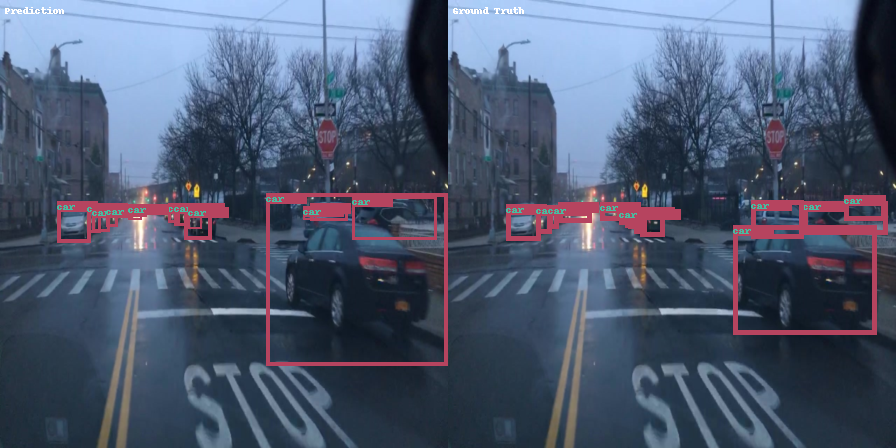

Processed frame 189
Object detection mAP@0.5 = 0.24


In [13]:
for t in range(num_steps):
    frame, annotation, raw_frame = data_gen()
    frame = quantize(frame)
    sender.send(frame)
    out = receiver.receive()
    out = dequantize(out)
    input_frame = frame_buffer(raw_frame)
    gt_ann = annotation_buffer(annotation)
    if input_frame is not None:  # valid output from FIFO buffer
        predictions = yolo_predictor(out)
        pred_bbox = nms(predictions)
        gt_bbox = obd.bbox.utils.tensor_from_annotation(gt_ann).cpu().data.numpy()
        yolo_monitor(input_frame, gt_bbox, pred_bbox)
    else:
        print(f'Frame {t} queued in pipeline.', end='\r')

sender.wait()
sender.stop()